In [1]:

import os
import pickle
import numpy as np
from PIL import Image
import trimesh
import open3d
import matplotlib.pyplot as plt
import cv2

import torch
from torch.utils.data import DataLoader

from pose_estimation.icp import icp
from pose_estimation import PoseData, PoseDataNPZ, PoseDataNPZTorch, COLOR_PALETTE
from pose_estimation.utils import back_project, show_points, compare_points, compute_rre, compute_rte, \
    crop_and_resize, crop_and_resize_multiple

WORKDIR = f"{os.getcwd()}/.."
DATA_FOLDER = os.path.join(WORKDIR, "data_folder")

MODELS_PATH = os.path.join(DATA_FOLDER, "models")
TRAIN_PATH = os.path.join(DATA_FOLDER, "training_data")
TEST_PATH = os.path.join(DATA_FOLDER, "testing_data")

TRAIN_NPZ_PATH = os.path.join(DATA_FOLDER, "dataset_npz")
TEST_NPZ_PATH = os.path.join(DATA_FOLDER, "dataset_npz_test")


In [2]:
source_banana = trimesh.load(f"{DATA_FOLDER}/banana.source.ply").vertices
target_banana = trimesh.load(f"{DATA_FOLDER}/banana.target.ply").vertices
gt_banana = np.loadtxt(f"{DATA_FOLDER}/banana.pose.txt")

RUN_ICP_SANITY = False
if RUN_ICP_SANITY:
    iterations = 20
    attempts = 10
    # Visualization
    T = icp(source_banana, target_banana, attempts=10)
    rre = np.rad2deg(compute_rre(T[:3, :3], gt_banana[:3, :3]))
    rte = compute_rte(T[:3, 3], gt_banana[:3, 3])
    print(f"rre={rre}, rte={rte}")
    compare_points(source_banana @ T[:3, :3].T + T[:3, 3], target_banana)


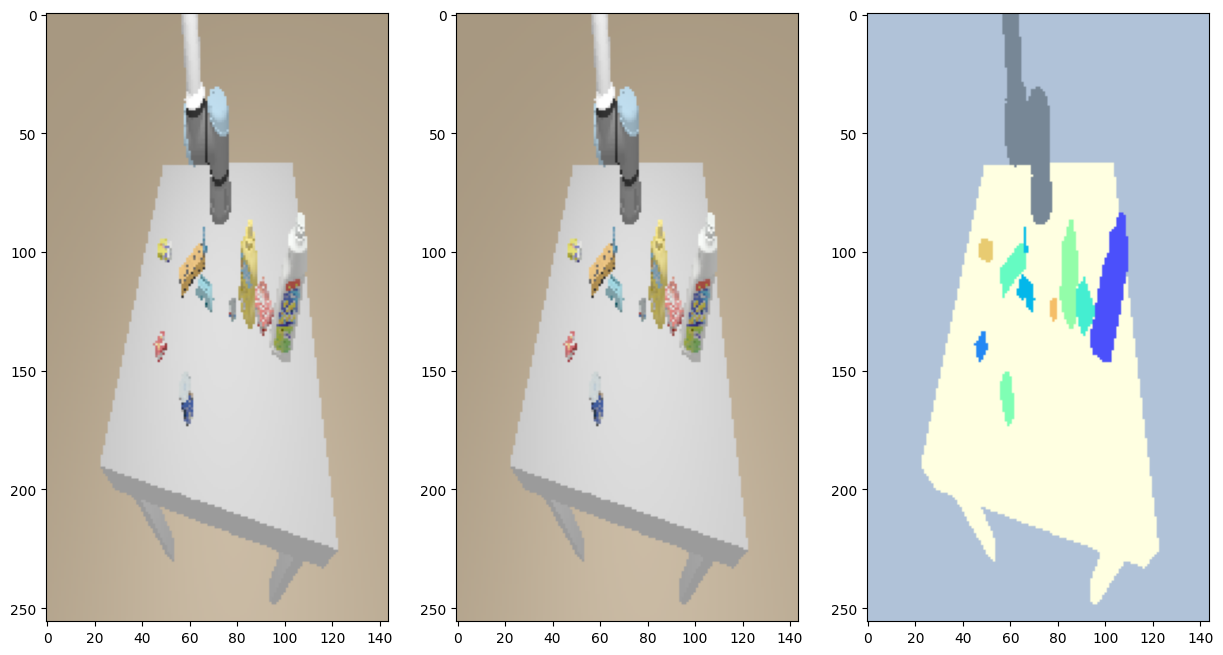

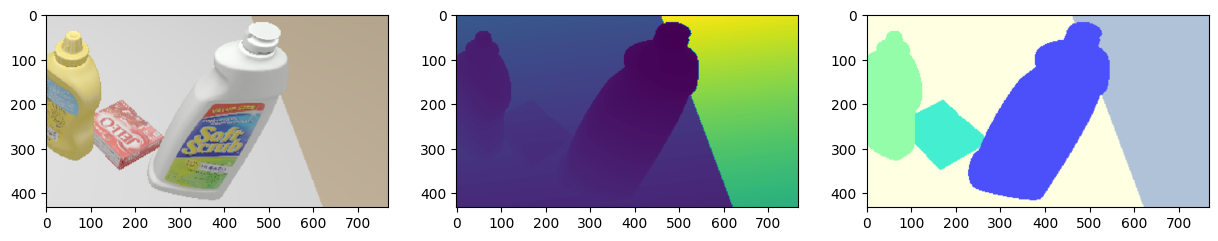

In [3]:

data = PoseData(TRAIN_PATH, MODELS_PATH)

scene = data[2, 1, 1]
rgb = scene["color"]()
depth = scene["depth"]()
label = scene["label"]()
meta = scene["meta"]

_size = (256, 144)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(cv2.resize(rgb, _size, interpolation=cv2.INTER_NEAREST))
plt.subplot(1, 3, 2)
plt.imshow(cv2.resize(rgb, _size, interpolation=cv2.INTER_NEAREST))
plt.subplot(1, 3, 3)
plt.imshow(cv2.resize(COLOR_PALETTE[label], _size, interpolation=cv2.INTER_NEAREST))  # draw colorful segmentation

mask = label == np.unique(label)[0]
target_size = (432, 768)
margin = 8
aspect_ratio = True
mask_fill = False

(rgb_cr, depth_cr, label_cr, mask_cr), scale, translate = crop_and_resize_multiple(
    (rgb, depth, COLOR_PALETTE[label], mask), mask, target_size=target_size, margin=margin, 
    aspect_ratio=aspect_ratio, mask_fill=mask_fill)


# print(depth[mask][:200])
# print(depth_cr[mask_cr][:200])

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb_cr)
plt.subplot(1, 3, 2)
plt.imshow(depth_cr)
plt.subplot(1, 3, 3)
plt.imshow(label_cr)  # draw colorful segmentation


[1.28       1.26315789 1.        ] [286 294   0]
(2, 1000)
1000
['bowl', 'bowl_a', 'cracker_box', 'gelatin_box', 'jenga', 'pan_tefal', 'plate', 'pudding_box', 'rubiks_cube', 'sugar_box']
[[ 0.99384739 -0.11039478 -0.00896435  0.14074121]
 [ 0.11028252  0.99382567 -0.01217826 -0.32843916]
 [ 0.01025342  0.01111472  0.99988566  0.04269925]
 [ 0.          0.          0.          1.        ]]
[[ 0.96043694 -0.27839687 -0.00749155  0.13903987]
 [ 0.27827123  0.9603933  -0.01448704 -0.33030072]
 [ 0.01122798  0.01182921  0.999867    0.04297212]
 [ 0.          0.          0.          1.        ]]

rre=9.826831472665562, rte=0.0025366100978076534


AssertionError: 

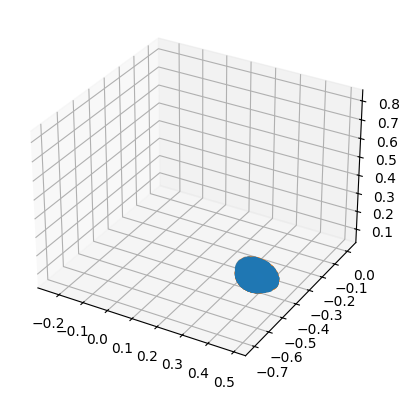

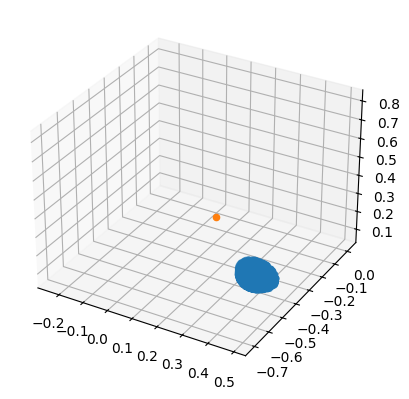

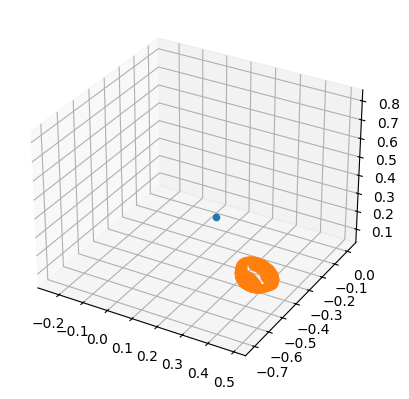

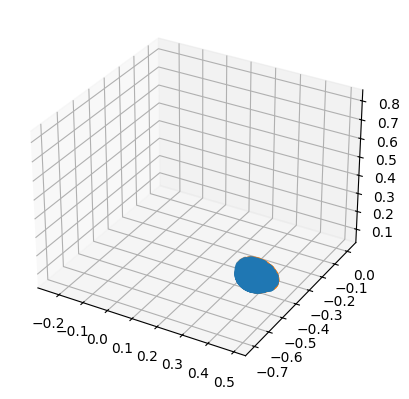

In [4]:
TEST_ICP = True
if TEST_ICP:

    selection = 3, 1, 44
    scene = data[selection]


    rgb = scene["color"]() * 255
    depth = scene["depth"]() / 1000
    label = scene["label"]()
    meta = scene["meta"]

    item = 0
    obj_id = meta["object_ids"][item]
    scale, translate = None, None

    MAX_SAMPLES = 1_000
    mask = label == obj_id
    target_size = (144, 256)
    margin = 12
    aspect_ratio = True
    mask_fill = False

    (rgb, depth, mask), scale, translate = crop_and_resize_multiple(
        (rgb, depth, mask), mask, target_size=target_size, margin=margin, 
        aspect_ratio=aspect_ratio, mask_fill=mask_fill)
    
    print(scale, translate)

    target_pcd, mask_indices = back_project(depth, meta, mask, (scale, translate), samples=MAX_SAMPLES)

    print(mask_indices.shape)

    print(len(target_pcd))

    mesh = data.get_mesh(obj_id)
    source_pcd, faces = trimesh.sample.sample_surface(mesh, MAX_SAMPLES)

    source_pcd = source_pcd * meta["scales"][obj_id]
    target_pcd = target_pcd # / meta["scales"][obj_id] # Back Projected

    print(meta["object_names"])

    camera_scale = 0.2
    camera_translate = np.mean(target_pcd, axis=0)

    attempts = 10
    # Visualization
    T = icp(source_pcd, target_pcd, attempts=attempts)

    print(T)
    gt_T = meta["poses_world"][obj_id]
    print(gt_T)
    print("")

    rre = np.rad2deg(compute_rre(T[:3, :3], gt_T[:3, :3]))
    rte = compute_rte(T[:3, 3], gt_T[:3, 3])
    print(f"rre={rre}, rte={rte}")

    compare_points(source_pcd @ T[:3, :3].T + T[:3, 3], target_pcd, scale=camera_scale, translate=camera_translate)

    # These are individual plots and will also point at the origin (stray points)
    compare_points(source_pcd @ T[:3, :3].T + T[:3, 3], np.zeros((1, 3)), scale=camera_scale, translate=camera_translate)
    compare_points(np.zeros((1, 3)), target_pcd, scale=camera_scale, translate=camera_translate)

    compare_points(source_pcd @ gt_T[:3, :3].T + gt_T[:3, 3], target_pcd,  scale=camera_scale, translate=camera_translate)

assert 0


In [ ]:
from pose_estimation import draw_projected_box3d

poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])

boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))


In [ ]:
ICP_RUN = True
if ICP_RUN:
    data = PoseData(TEST_PATH, MODELS_PATH)

    MESH_SAMPLES = None
    ICP_ATTEMPTS = 10

    results = {}
    print(len(data))
    for i, key in enumerate(data.keys()):

        print(i, key)

        l, s, v = key

        scene = data[key]

        rgb = scene["color"]() * 255
        depth = scene["depth"]() / 1000
        label = scene["label"]()
        meta = scene["meta"]
        
        back_projection = back_project(depth, meta)

        world_frames = [None] * 79

        object_ids = [object_id for object_id in np.unique(label) if object_id < 79]

        for object_id in object_ids:

            indices = np.where(label == object_id)
            obj_pnts = back_projection[indices]
            obj_rgb = rgb[indices]

            mesh = data.get_mesh(object_id)
            source_pcd, faces = trimesh.sample.sample_surface(mesh, len(obj_pnts) if MESH_SAMPLES in [-1, 0, None, False] else MESH_SAMPLES)

            source_pcd = source_pcd * meta["scales"][object_id]
            target_pcd = obj_pnts

            T = icp(source_pcd, target_pcd, attempts=ICP_ATTEMPTS)

            world_frames[object_id] = T.tolist()

            results[f"{l}-{s}-{v}"] = {"poses_world" : world_frames}


In [ ]:
import json
with open("results.json", "w") as f:
    json.dump(results, f)
